Things that still need to be added:<br>

Changes to the code/methods/similar:<br>
    -Add a log with the output:<br>
        -Final values<br>
        -The output log needs some organization work<br>
        -JHK fits (see below, this might not be worth it) <br>
        -EBV priors from dust maps https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/A%2BA/625/A135 ?<br>
        &nbsp;&nbsp; &nbsp;&nbsp;https://stilism.obspm.fr/scripts <br>
        -Bayestar19 for north  of -30?
    
Make plots look cooler:<br>
    -Make points smaller if there are a lot, bigger if few (point size scaling)<br>
    -Better use of alpha when plotting lots of points?<br>
    -Quite a bit of whitespace to fill?<br>
    -Add reddening vector?<br>
   

Tests to run:<br>
    -Other datasets with established ages (beta pic?)<br>
    ~&nbsp;&nbsp;-MELANGE-1 (240+/-40, consistent with published)~<br>
    ~&nbsp;&nbsp;-LCC groups (Getting consistent ages between Kerr and Goldman)~<br>
    &nbsp;&nbsp;-Pleiades<br>

Have to wait for help:<br>
    -Updates for edr3 from Feiden<br>

Long-term:<br>
    -Fitting many mangitudes instead if just one sequence (i.e., P(G,Bp,Rp,J,H,K|age) = )<br>
      Note: the way to do this is to give the input as a distance (or plx) and age, and then compute a given set of apparent magnitudes predicted by the model. What does the outlier distribution look like then? Is there an outlier distribution for each magnitude? <br>
       Update: this is problematic for a lot of reasons. A big one is that Gaia is resolving out a lot of binaries that 2MASS is not... I think this is more effort than it's worth. <br>
    -Don't bother with JHK for similar reasons, but also because of the cross-match issue<br>

In [1]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
from astroquery.vizier import Vizier
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
#from isochrones.interp import DFInterpolator
import numpy.random as random
import emcee
import corner
import random
import scipy.integrate as integrate
from scipy import interpolate
from scipy import optimize
import math as math
from astroquery.mast import Catalogs
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord
import multiprocessing
import os
from multiprocessing import Pool
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import cpu_count
plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9

import warnings
warnings.filterwarnings('ignore')

Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


Currently have 3 run types:<br>
-Normal: good for if the major interlopers are field M dwarfs (most common situation)<br>
-Binary: good if membership list is solid but binaries are an issue<br>
-Hybrid: good for a mix, models outliers as offset from the isochrone in any direction. Most reliable method <br>

In [2]:
## make some basic decisions about 

## options are feiden_mag, feiden_std for now. Note that Feiden is DR2, and not suggested.
usegrid = 'parsec'#'parsec'#feiden_mag' 
fittype = 'hybrid' ## options are normal, binary, and hybrid. See above
ruwecut = 1.2 ## use 1.2 (agressive) to remove binaries, increase to 1.3--1.4 if more stars are needed
filetype = 'radec' ### or kraus. This is meant for reading in the file. just use radec

## it's going to look for a file called datafile.txt. I know, datafile.txt is probably a csv... 
## Listen, I'm a professor, not a programmer. Deal with it. 
datafile = 'TOI1227'
#'hd109833_banyan_v2_hp'#'KOI-3876'#''HD109833'#'KOI-3876'#'cut_candidates'#'HD109833'

##I think this is just for plot labeling? 
targname = 'TOI1227'#'HD109833'#'KOI-3876'#
targcoord = SkyCoord(ra=186.7673449, dec=-72.4518516,unit=(u.degree, u.degree), frame='icrs')##toi1227
#targcoord = SkyCoord(ra=341.9709064, dec=49.9180719, unit=(u.degree, u.degree), frame='icrs')
#targcoord = SkyCoord(ra=189.77583262267967, dec=-74.57402138790371, unit=(u.degree, u.degree), frame='icrs')

#This will be the name of the folder with the data. Useful if running targets with different settings. 
foldername = 'TOI1227'

## don't change this
whichgaia = 'edr3' ## source of colors and mags from Gaia (not relevant if using 2mass only)

##bprp or grp. I've got better fits with grp, but I often run both to make sure I'm not doing something stupid. 
usecol = 'bprp' ## color
usemag = 'g' ## mag

##Lol, what a mess... 
file_endian = fittype+'_'+usegrid+'_'+usecol+'_'+usemag+'_'+whichgaia ## will be used for output file names

## the code only grabs the relevant part of models (to save runtime)
## So this actually needs to be within a factor of a few or it grabs the wrong model grids.
guessage = 10 ## Myr;
burn=     2000
nsteps = 20000
## the code will output a note saying it didn't converge if this isn't large enough. I've found 5-10k steps is usually good

## these are for plotting. 
if usecol == 'grp':
    xlabel = r'$G - R_P$ (mag)'
    colrange = [-0.15,1.5]
if usecol == 'bprp':
    xlabel = r'$B_P - R_P$ (mag)'
    colrange = [-0.2,4]
if usecol == 'gj':
    xlabel = r'$G - J$ (mag)'
    colrange = [-0.2,4]##??
if usecol == 'jk':
    xlabel = r'$J - K$ (mag)'
    colrange = [-0.1,1.3]##??
if usemag == 'g':
    ylabel = r'$M_G$ (mag)'
    magrange = [13.5,0]
if usemag == 'k':
    ylabel = r'$M_K$ (mag)'
    magrange = [9,0]

In [3]:
#First setup the folder that will contain any output.
#If the folder exists, that's OK, with the caveat that it might overwrite things. 
if os.path.isdir(foldername):
    print('Using exitsing folder')
else:
    print('Making new folder')
    os.system('mkdir '+foldername)
    
##Log with results
log_name = foldername+'/log_'+file_endian+'.txt'
os.system('rm '+log_name)
log = open(log_name,'x')
log.write('Log for '+targname+' '+datafile+'\n')
log.write('Fit type: '+fittype)
log.write('RUWE cut: '+str(ruwecut)+'\n')
log.write(str(whichgaia)+', '+usecol+' color and '+usemag+' mag \n')
log.write('model grid: '+usegrid+'\n')
log.write('Nsteps: '+str(nsteps)+', Burn: '+str(burn)+ '\n')
log.write('Guess age: '+str(guessage)+'\n')

print('Log name: '+log_name)


Using exitsing folder
Log name: TOI1227/log_hybrid_parsec_bprp_g_edr3.txt


In [4]:
##First we need to read in the model grid and make sure things are in the format we want. 
if usegrid == 'parsec':
    filename = 'parsec_grid_allage.csv'
    grid = pd.read_csv(filename, dtype='float32',comment='#')
    if usemag == 'g':
        modelmag = grid['gaia_gmag'].values
    if usemag == 'k':
        modelmag = grid['2mass_kmag'].values
    if usecol == 'grp':
        modelcol = grid['gaia_gmag'].values-grid['gaia_rpmag'].values
    if usecol == 'bprp':
        modelcol = grid['gaia_bpmag'].values-grid['gaia_rpmag'].values
    if usecol == 'gj':
        modelcol = grid['gaia_gmag'].values-grid['2mass_jmag'].values
    if usecol == 'jk':
        modelcol = grid['2mass_jmag'].values-grid['2mass_kmag'].values
        
    modelg = grid['gaia_gmag'].values
    modelr = grid['gaia_rpmag'].values
    modelage = grid['age'].values#(10**(grid['logAge'].values))/1e6
    
    if guessage >= 80:
        good = np.where((grid['mass'].values<3) 
                        & (modelage > guessage/5) 
                        & (modelage<guessage*5)
                        & ((modelg-modelr)<1.5)
                        & (modelg < 16)
                        & (modelage % 0.5 == 0) ## this is to densensify the grid, only use if guessage is large
                       )
    else:
            good = np.where((grid['mass'].values<3) 
                    & (modelage > guessage/10) 
                    & (modelage<guessage*5)
                    & ((modelg-modelr)<1.5)
                    & (modelg < 16)
                    )
    modelmag = modelmag[good]
    modelcol = modelcol[good]
    modelage = modelage[good]
    modelg = modelg[good]
    modelr = modelr[good]
    
if usegrid == 'feiden_mag':
    filename = 'feiden_grid_mag_interpolated.csv'
    grid = pd.read_csv(filename, dtype='float32',comment='#')
    if usemag == 'g':
        modelmag = grid['gaia_gmag'].values
    if usemag == 'k':
        modelmag = grid['2mass_kmag'].values
    if usecol == 'grp':
        modelcol = grid['gaia_gmag'].values-grid['gaia_rpmag'].values
    if usecol == 'bprp':
        modelcol = grid['gaia_bpmag'].values-grid['gaia_rpmag'].values
    if usecol == 'gj':
        modelcol = grid['Gmag'].values-grid['2mass_jmag'].values
    if usecol == 'jk':
        modelcol = grid['2mass_jmag'].values-grid['2mass_kmag'].values
    
    modelg = grid['gaia_gmag'].values
    modelr = grid['gaia_rpmag'].values
    modelage = grid['age']##(10**(grid['logAge'].values))/1e6

log.write('Min model age = '+str(np.min(modelage))+', max model age = '+str(np.max(modelage))+
          ' total model points = '+str(np.size(modelage))+'\n')
          
print('Min model age = '+str(np.min(modelage))+', max model age = '+str(np.max(modelage))+
          ' total model points = '+str(np.size(modelage))+'\n')

Min model age = 1.2, max model age = 49.8 total model points = 21132



This downloads the data from Gaia<br>
I'm pretty certain if I took 20m to re-learn SQL I could do this faster with the direct API. But eh...<br>

In [5]:
if os.path.exists(foldername+'/'+datafile+'.csv'):
    data = pd.read_csv(foldername+'/'+datafile+'.csv', sep=',')
    g = data['G'].values
    g_err = data['G_err'].values
    bp = data['BP'].values
    bp_err = data['BP_err'].values
    rp = data['RP'].values
    rp_err = data['RP_err'].values
    plx = data['plx'].values
    eplx = data['eplx'].values
    ruwe = data['ruwe'].values
    ra = data['ra'].values
    dec = data['dec'].values
    jm = data['jm'].values
    jm_err = data['jm_err'].values
    hm = data['hm'].values
    hm_err = data['hm_err'].values
    km = data['km'].values
    km_err = data['km_err'].values
    voff = data['voff'].values
    sep_deg = data['sep_deg'].values
    sep_3d = data['sep_3d'].values
    vr_pred = data['vr_pred'].values
    vr_obs = data['vr_obs'].values
    vr_obserr = data['vr_obserr'].values
    ## apply any cuts on the dataset
    l = np.where(voff < 100)
    g = g[l]
    g_err = g_err[l]
    bp = bp[l]
    bp_err = bp_err[l]
    rp = rp[l]
    rp_err = rp_err[l]
    plx = plx[l]
    eplx = eplx[l]
    ruwe = ruwe[l]
    ra = ra[l]
    dec = dec[l]
    jm = jm[l]
    jm_err = jm_err[l]
    hm = hm[l]
    hm_err = hm_err[l]
    km = km[l]
    km_err = km_err[l]
else:
    data=pd.read_csv(datafile+'.txt', sep=',')
    ra = data['RA'].values
    dec = data['DEC'].values
    ##ruwe = data['RUWE'].values
    if filetype == 'radec':
        voff = np.zeros(np.size(ra))
        sep_deg = np.zeros(np.size(ra))
        sep_3d = np.zeros(np.size(ra))
        vr_pred = np.zeros(np.size(ra))
        vr_obs = np.zeros(np.size(ra))
        vr_obserr = np.zeros(np.size(ra))
    else:
        voff = data['Voff(km/s)'].values
        sep_deg = data['Sep(deg)'].values
        sep_3d = data['3D(pc)'].values
        vr_pred = data['Vr(pred)'].values
        vr_obs = data['Vr(obs)'].values
        vr_obserr = data['Vrerr'].values
    
    width = u.Quantity(0.001, u.deg)
    height = u.Quantity(0.001, u.deg)
    if whichgaia == 'edr3':
        Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"
    if whichgaia == 'dr2':
        Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"

    g = []
    g_err = []
    bp = []
    bp_err = []
    rp = []
    rp_err = []
    plx = []
    eplx = []
    jm = []
    jm_err = []
    hm = []
    hm_err = []
    km = []
    km_err = []
    ruwe = []
    ii = 0
    v = Vizier(columns=["*", "+_r"], catalog="II/246")
    rad = "6s"
    print('Running',np.size(ra),'targets through Gaia and 2Mass')
    for r,d in zip(ra,dec):
        ## 2mass first:
        coord = SkyCoord(ra=r, dec=d, unit=(u.degree, u.degree), frame='icrs')
        result = v.query_region(coord,radius=rad)
        if np.size(result) >= 1:
            jm = np.append(jm,(result[0]['Jmag'][0]))
            jm_err = np.append(jm_err,(result[0]['e_Jmag'][0]))
            hm = np.append(hm,(result[0]['Hmag'][0]))
            hm_err = np.append(hm_err,(result[0]['e_Hmag'][0]))
            km = np.append(km,(result[0]['Kmag'][0]))
            km_err = np.append(km_err,(result[0]['e_Kmag'][0]))
        else:
            jm = np.append(jm,np.nan)
            jm_err = np.append(jm_err,np.nan)
            hm = np.append(hm,np.nan)
            hm_err = np.append(hm_err,np.nan)
            km = np.append(km,np.nan)
            km_err = np.append(km_err,np.nan)
        
        
        catalog_data = Gaia.query_object_async(coordinate=coord, width=width, height=height,verbose=False)
        if np.size(catalog_data) >= 1:
            bp = np.append(bp,catalog_data['phot_bp_mean_mag'][0])
            bp_err = np.append(bp_err,1.0/catalog_data['phot_bp_mean_flux_over_error'][0])
            g = np.append(g,catalog_data['phot_g_mean_mag'][0])
            g_err = np.append(g_err,1.0/catalog_data['phot_g_mean_flux_over_error'][0])
            rp = np.append(rp,catalog_data['phot_rp_mean_mag'][0])
            rp_err = np.append(rp_err,1.0/catalog_data['phot_rp_mean_flux_over_error'][0])
            plx = np.append(plx,catalog_data['parallax'][0])
            eplx = np.append(eplx,catalog_data['parallax_error'][0])
            ruwe = np.append(ruwe,catalog_data['ruwe'][0])

        else:
            print('failed ',r,d)
            bp = np.append(bp,np.nan)
            bp_err = np.append(bp_err,np.nan)
            g = np.append(g,np.nan)
            g_err = np.append(g_err,np.nan)
            rp = np.append(rp,np.nan)
            rp_err = np.append(rp_err,np.nan)
            plx = np.append(plx,np.nan)
            eplx = np.append(eplx,np.nan)
        ii+=1
        #print(bp[-1]-rp[-1],g[-1]-km[-1],jm[-1]-km[-1])
    print('saving data to '+datafile+'.csv')
    df = pd.DataFrame({"G":g,"G_err":g_err,"BP":bp,"BP_err":bp_err,"RP":rp,"RP_err":rp_err,
                       "plx":plx,"eplx":eplx,"ruwe":ruwe,"ra":ra,"dec":dec,
                       "jm":jm,"jm_err":jm_err,"hm":hm,"hm_err":hm_err,"km":km,"km_err":km_err,
                       "voff":voff, "sep_deg":sep_deg,"sep_3d":sep_3d,"vr_pred":vr_pred,"vr_obs":vr_obs,"vr_obserr":vr_obserr
                       })
    df.to_csv(foldername+'/'+datafile+".csv", index=False)


In [6]:
## UGHH, can you get rid of this damned "INFO: Query finished." crap?
## it's annoying!!

In [7]:
## here is where we will correct for the parallax systematics from El-Badry
## technically only good for RUWE<1.4
a = 0.21
g0 = 12.65
b = 0.90 
p0 = 1.141
p1 = 0.0040
p2 = -0.00062
f = a*np.exp(-1*(g-g0)**2/b**2)+p0+ p1*g+ p2*g**2
eplx*=f

## select which observational parameters to use 
if usecol == 'grp':
    col = g-rp
    colerr = np.sqrt(np.square(g_err)+np.square(rp_err))
    coltest = [0.0,0.2,0.4,0.8] ## reasonable range of colors
if usecol == 'bprp':
    col = bp-rp
    colerr = np.sqrt(np.square(bp_err)+np.square(rp_err))
    coltest = [0.6,1.6,2.7,3.5]
if usecol == 'gj':
    col = g-jm
    colerr = np.sqrt(np.square(g_err)+np.square(jm_err))
    coltest = [0.5,1.5,2.5,3.5]
if usecol == 'jk':
    col = jm-km
    colerr = np.sqrt(np.square(jm_err)+np.square(km_err))
    coltest = [-0.1,0.1,0.3,0.5]
if usemag == 'k':
    mag = km-5.0*(np.log10(1000./plx)-1)
    tmp = eplx*(5./(plx*np.log(10.)))
    magerr = np.sqrt(km_err**2 + (tmp)**2) 
if usemag == 'g':
    mag = g-5.0*(np.log10(1000./plx)-1)
    tmp = eplx*(5./(plx*np.log(10.)))
    magerr = np.sqrt(g_err**2 + (tmp)**2) 
    

In [8]:
#Consider removing this part of the code depending on what kinda plots you want.

## change the plot range based on the data
## take the smaller (narrower window) of the two
l = np.where(np.isfinite(mag))
buffer = 0.1
if np.min(col[l])-buffer > colrange[0]:
    colrange[0] = np.min(col[l])-buffer
if np.max(col[l])+buffer < colrange[1]:
    colrange[1] = np.max(col[l])+buffer
if np.max(mag[l])+buffer < magrange[0]:
    magrange[0] = np.max(mag[l])+buffer
if np.min(mag[l])-buffer > magrange[1]:
    magrange[1] = np.min(mag[l])-buffer
print(np.min(mag[l]),np.max(mag))
print(colrange,magrange)

-5.040633400801095 14.910880380550239
[-0.2, 4] [13.5, 0]


cat


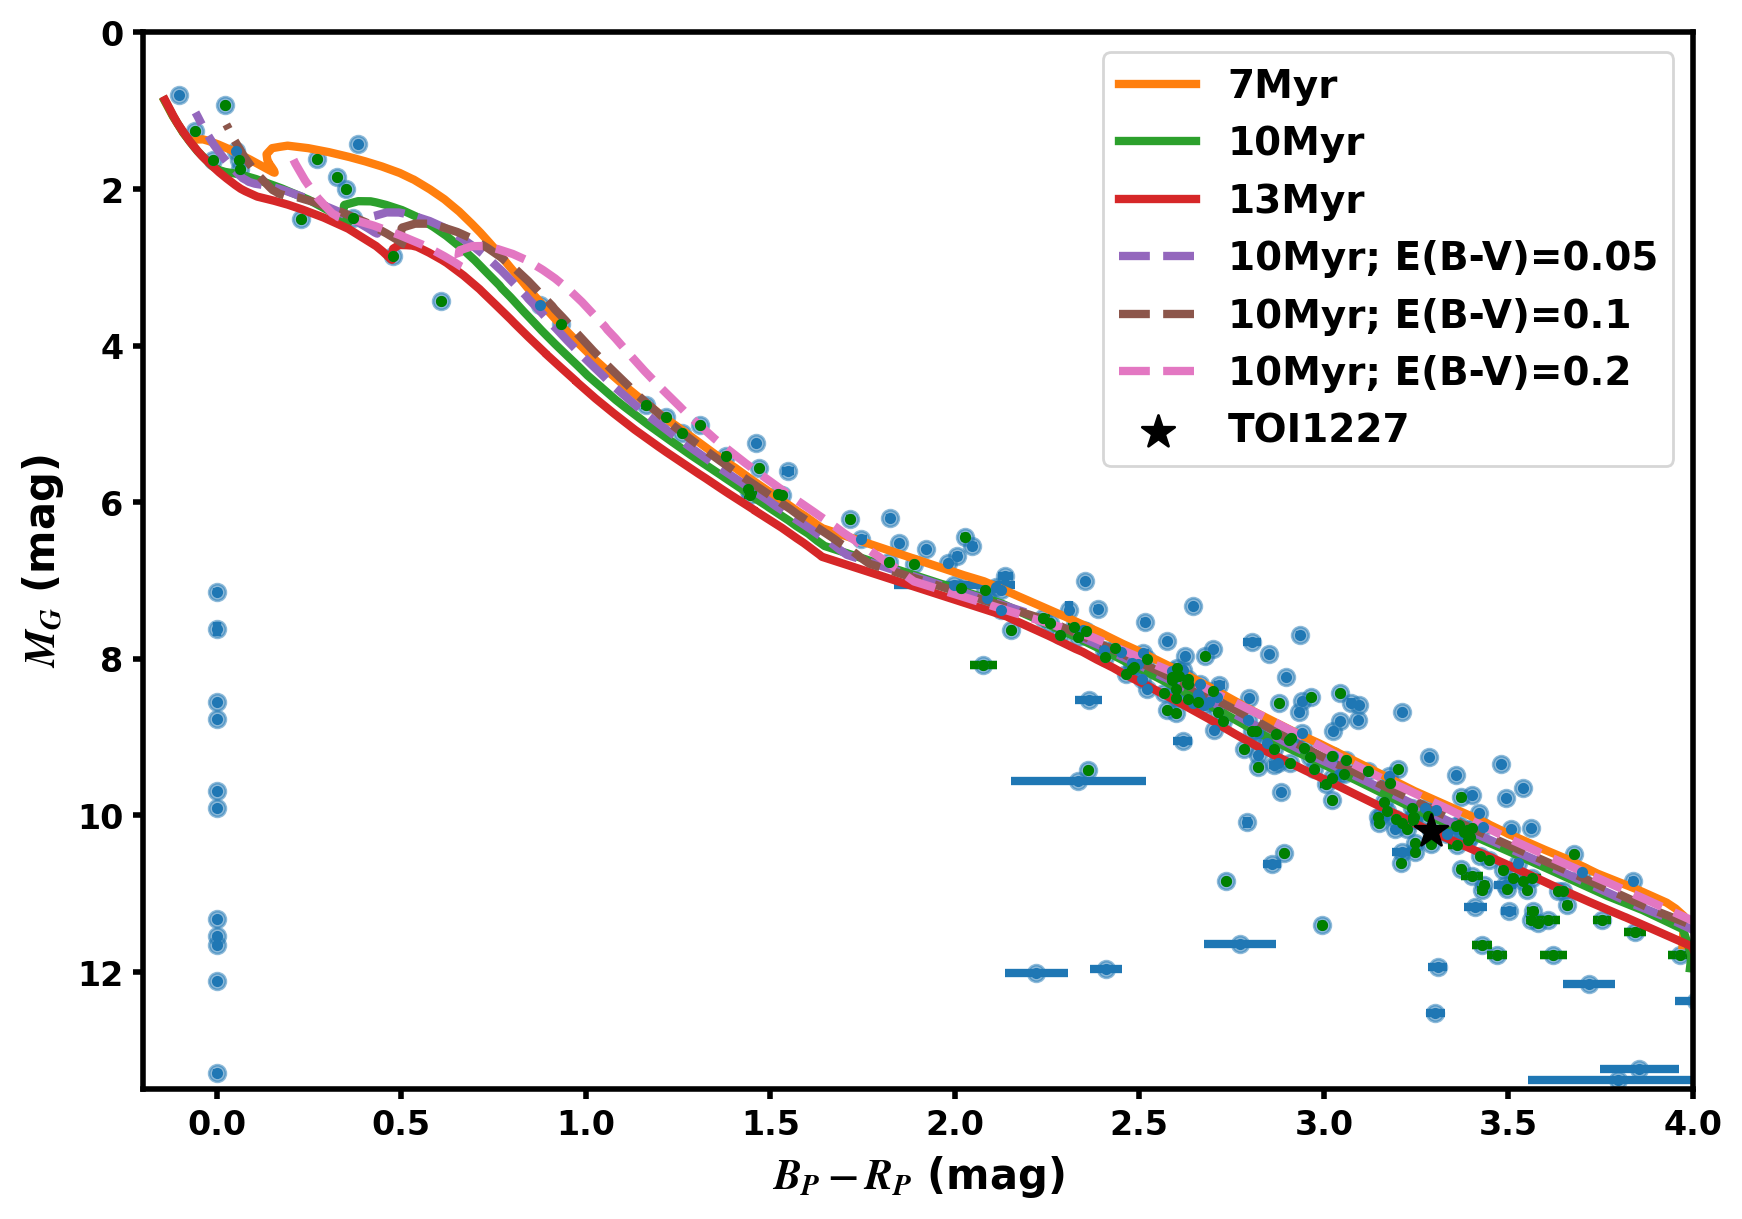

In [9]:
catcord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
if 'targcoord' in locals():
    print('cat')
    l = np.where(targcoord.separation(catcord) == np.min(targcoord.separation(catcord)))
else:
    l = 0
    targcoord = SkyCoord(ra=ra[0]*u.degree, dec=dec[0]*u.degree, frame='icrs')
    
fig, axes = plt.subplots(figsize=(10, 7), sharex=True)
if (targcoord.separation(catcord))[l] < 5*u.arcsec:
    targcol = col[l]
    targmag = mag[l]   
    axes.scatter(targcol,targmag,label=targname,marker='*',zorder=4,color='black',s=150)
else:
    targcol = np.NAN
    targmag = np.NAN
    
axes.errorbar(col,mag,xerr=colerr,yerr=magerr,fmt=' ',marker='.')
axes.set_ylim(magrange[0],magrange[1])
axes.set_xlim(colrange[0],colrange[1])

for age in np.array([guessage*0.7,guessage,guessage*1.3]):
    l = np.squeeze(np.where(np.abs(modelage-age) == np.min(np.abs(modelage-age))))
    axes.plot(modelcol[l],modelmag[l],label=str(int(age))+'Myr')

grp_red = [-0.18,-0.08,0.02,0.12,0.22,0.32,0.42 ,0.52 ,0.62 ,0.72 ,0.82,0.92 ,1.02 ,1.12 ,1.22,1.32 ,1.42]
RG = [3.112,3.05 ,2.99 ,2.961,2.90 ,2.80 ,2.68 ,2.570,2.507,2.397,2.30 ,2.211,2.157,2.057,1.930,1.852,1.818]
RRP = [1.938,1.930,1.923,1.919,1.908,1.90,1.881,1.865,1.860,1.842,1.823,1.796,1.769,1.735,1.687,1.656,1.641]
RBP = [3.670,3.59,3.53,3.504,3.47,3.40,3.34,3.257,3.206,3.124,3.04,3.000,3.000,2.965,2.944,2.924,2.912]
fg = interpolate.interp1d(grp_red,RG,fill_value='extrapolate')
frp = interpolate.interp1d(grp_red,RRP,fill_value='extrapolate')
fbp = interpolate.interp1d(grp_red,RBP,fill_value='extrapolate')
if usecol == 'grp':
    mag1corr = fg
    mag2corr = frp
if usecol == 'bprp':
    mag1corr = fbp
    mag2corr = frp
magcorr = fg
modelgrp = modelg-modelr
age = guessage

bounds = [np.min(modelmag[l]),np.max(modelmag[l]),np.min(modelcol[l]),np.max(modelcol[l])]
if usecol == 'jk':
    bounds = [np.min(modelmag[l])+0.1,np.max(modelmag[l])-0.1,np.min(modelcol[l])+0.1,np.max(modelcol[l])+0.1]


l = np.squeeze(np.where((np.abs(modelage-age) == np.min(np.abs(modelage-age))) & (modelg > bounds[0]) & (modelg < bounds[1]) ))
for EBV in np.array([0.05,0.10,0.20]):
    axes.plot(modelcol[l]+EBV*(mag1corr(modelgrp[l])-mag2corr(modelgrp[l])),
              modelmag[l]+EBV*magcorr(modelgrp[l]),'--',
              label=str(int(age))+'Myr; E(B-V)='+str(EBV))
axes.legend(fontsize=14)
axes.set_xlabel(xlabel)
axes.set_ylabel(ylabel)
fig.savefig(foldername+'/TestCMD1'+file_endian+'.pdf',dpi=400)

## define the reasonable bounds for the model interpolation and run a test set
l = np.squeeze(np.where(np.abs(modelage-guessage) == np.min(np.abs(modelage-guessage))))
f = interpolate.interp1d(modelcol[l],modelmag[l],fill_value='extrapolate')
mag_predict = f(coltest)
log.write('Predicted mags (check for weird values or NaN: '+str(mag_predict)+'\n')
log.write('Model mag and color limits for the given age:'+'\n')
log.write(str(np.min(modelmag[l]))+' '+str(np.max(modelmag[l]))+' '+str(np.min(modelcol[l]))+' '+str(np.max(modelcol[l])))
log.write('\n')

good = np.squeeze(np.where((mag > bounds[0]) & 
                        (mag < bounds[1]) & 
                        (col > bounds[2]) & 
                        (col < bounds[3]) & 
                        (ruwe < ruwecut) & 
                        (np.abs(col) > 0.00001) &
                        np.isfinite(col))
                 )

plt.scatter(col,mag,alpha=0.5)
plt.errorbar(col[good],mag[good],xerr=colerr[good],yerr=magerr[good],marker='.',fmt=' ',alpha=1,color='g')
plt.xlim(colrange[0],colrange[1])
plt.ylim(magrange[0],magrange[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.savefig(foldername+'/TestCMD2'+file_endian+'.pdf',dpi=400)    
    
    
col1 = np.array(col[good])
mag1 = np.array(mag[good])
colerr1 = np.array(colerr[good])
magerr1 = np.array(magerr[good])
ra1 = np.array(ra[good])
dec1 = np.array(dec[good])
ruwe1 = np.array(ruwe[good])
mask = np.ones(len(data), np.bool)
mask[good] = 0

bad = mask
col2 = np.array(col[bad])
mag2 = np.array(mag[bad])
colerr2 = np.array(colerr[bad])
magerr2 = np.array(magerr[bad])
ra2 = np.array(ra[bad])
dec2 = np.array(dec[bad])
ruwe2 = np.array(ruwe[bad])
bp2 = np.array(bp[bad])
rp2 = np.array(rp[bad])
g2 = np.array(g[bad])

## write to a file the rejected sources for manual inspection:
baddies_name = foldername+'/baddies'+file_endian+'.txt'
##   RA, Dec, g, Bp, Rp, Mag, Col, Ruwe
fmt1 = "%11.7f %11.7f %6.3f %6.3f %6.3f %6.3f %6.3f %6.3f"
os.system('rm '+baddies_name)
baddies = open(baddies_name,'x')
baddies.write('RA           DEC          Gmag   Bp     Rp     Mg     Col    RUWE  \n')
for i in np.arange(np.size(ra2)):
    j = int(np.squeeze(i))
    baddies.write(fmt1 % (ra2[j],dec2[j],g2[j],bp2[j],rp2[j],mag2[j],col2[j],ruwe2[j]))
    baddies.write("\n")
    
baddies.close()

So it's worth eye-balling that plot. You want to see if the tool removed a lot of the funny stars. 

In [10]:
def ln_prior(theta,fittype):
    age, EBV, Pb, Yb, Vb, sys = theta
    if (fittype == 'normal') or (fittype == 'hybrid'):
        if 0 < age < 500 and 0 <= Pb <= 0.9 and -50 <= Yb <= 50 and 0 <= Vb <= 50 and sys >= 0 and 1.0 >= EBV >= -0.15:
            sigma2 = 0.05**2
            val = 0
            p1 = (1. / np.sqrt(2 * np.pi * sigma2)) * np.exp(-(sys-val)**2/(2 * sigma2))
            #sigma2 = 0.07**2
            #val = 0.06
            #p2 = (1. / np.sqrt(2 * np.pi * sigma2)) * np.exp(-(EBV-val)**2/(2 * sigma2))
            return np.log(p1)
    if fittype == 'binary':
        if 0 < age < 500 and 0 <= Pb <= 0.9 and -1 <= Yb <= 0 and 0 <= Vb <= 1 and sys >= 0 and 1.0 >= EBV >= -0.15:
            sigma2 = 0.03**2
            val = 0
            p1 = (1. / np.sqrt(2 * np.pi * sigma2)) * np.exp(-(sys-val)**2/(2 * sigma2))
            sigma2 = 0.1**2
            val = -0.4
            p2 = (1. / np.sqrt(2 * np.pi * sigma2)) * np.exp(-(Yb-val)**2/(2 * sigma2))
            return np.log(p1+p2)
    return -np.inf

def ln_likelihood(theta, fittype, mag1corr, mag2corr, magcorr, modelgrp, modelage, modelmag, modelcol, 
                  col, mag, colerr, magerr):
    age, EBV, Pb, Yb, Vb, sys = theta
    
    l = np.squeeze(np.where(np.abs(modelage-age) == np.min(np.abs(modelage-age))))
    redcol = modelcol[l]+EBV*(mag1corr(modelgrp[l])-mag2corr(modelgrp[l]))
    redmag = modelmag[l]+EBV*magcorr(modelgrp[l])
    f = interpolate.interp1d(redcol,redmag,fill_value='extrapolate')
    mag_predict = f(col)
    mag_predict2 = f(col+colerr)
    err2 = np.abs(mag_predict2-mag_predict)

    sigma2 = magerr**2+err2**2+sys**2
    p_fg = ((1-Pb) / np.sqrt(2 * np.pi * sigma2)) * np.exp(-(mag-mag_predict)**2/(2 * sigma2))
    ## this needs to be fixed
    ## separate out the 'hybrid' case. In that case, do not apply the reddening correction to the 
    ## outlier population. It should apply to the binary population. 
    if fittype == 'hybrid':
        f = interpolate.interp1d(modelcol[l],modelmag[l],fill_value='extrapolate')
        mag_predict_nored = f(col)
        p_bg = (Pb / np.sqrt(2 * np.pi * (Vb + sigma2))) * np.exp(-((mag-mag_predict_nored)-Yb)**2/(2 * (Vb + sigma2)))        
    if fittype == 'binary':
        p_bg = (Pb / np.sqrt(2 * np.pi * (Vb + sigma2))) * np.exp(-((mag-mag_predict)-Yb)**2/(2 * (Vb + sigma2)))
    if fittype == 'normal':
        p_bg = (Pb / np.sqrt(2 * np.pi * (Vb + sigma2))) * np.exp(-(mag-Yb)**2/(2 * (Vb + sigma2)))
        
    output = np.sum(np.log(p_fg + p_bg))
    if np.isfinite(output):
        return output
    else:
        return -np.inf
    
def ln_posterior(theta, fittype, mag1corr, mag2corr, 
                 magcorr, modelgrp, modelage, modelmag, modelcol, 
                 col, mag, colerr, magerr):
    ln_p = ln_prior(theta, fittype)
    if not np.isfinite(ln_p):
        return -np.inf
    return ln_p + ln_likelihood(theta, fittype, mag1corr, mag2corr, 
                                magcorr, modelgrp, modelage, modelmag, modelcol, 
                                col, mag, colerr, magerr)

In [11]:
if fittype == 'binary' or fittype == 'hybrid':
    initial_guesses = [guessage, 0.1, 0.1, -0.3, 1, 0.05]
else:
    initial_guesses = [guessage, 0.1, 0.1, 10, 5, 0.05]
    
ndim = np.size(initial_guesses)
pos0 = []
counter = 0
randomizer = [1, 0.001, 0.005, 0.1, 0.1,0.001]
nwalkers = ndim*5

while len(pos0) < nwalkers:
    counter+=1
    if counter > 5000:
        print('failed to initialize walkers, check the initial conditions and/or input data')
        break 
    trial = initial_guesses + randomizer * np.random.randn(ndim)
    age, EBV, Pb, Yb, Vb, sys = trial
    lp = ln_posterior(trial, fittype, mag1corr, mag2corr, 
                      magcorr, modelgrp, modelage, modelmag, modelcol, 
                      col1, mag1, colerr1, magerr1)
    if np.isfinite(lp):
        pos0.append(trial)
#print(trial)
#print(ln_prior(trial,fittype))

In [12]:
filename = foldername+'/'+"mix_ages_backend.h5"
backend = emcee.backends.HDFBackend(filename)
os.system("rm "+filename)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, backend=backend, 
                                args=(fittype, mag1corr, mag2corr, magcorr, modelgrp, modelage, modelmag, modelcol,col1, mag1, colerr1, magerr1), threads=8)
sampler.run_mcmc(pos0, nsteps, progress=True)
print('done with mcmc')

100%|██████████| 20000/20000 [05:52<00:00, 56.66it/s]

done with mcmc


Chain at least 50x the autocorrelation time. 6025 20000


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

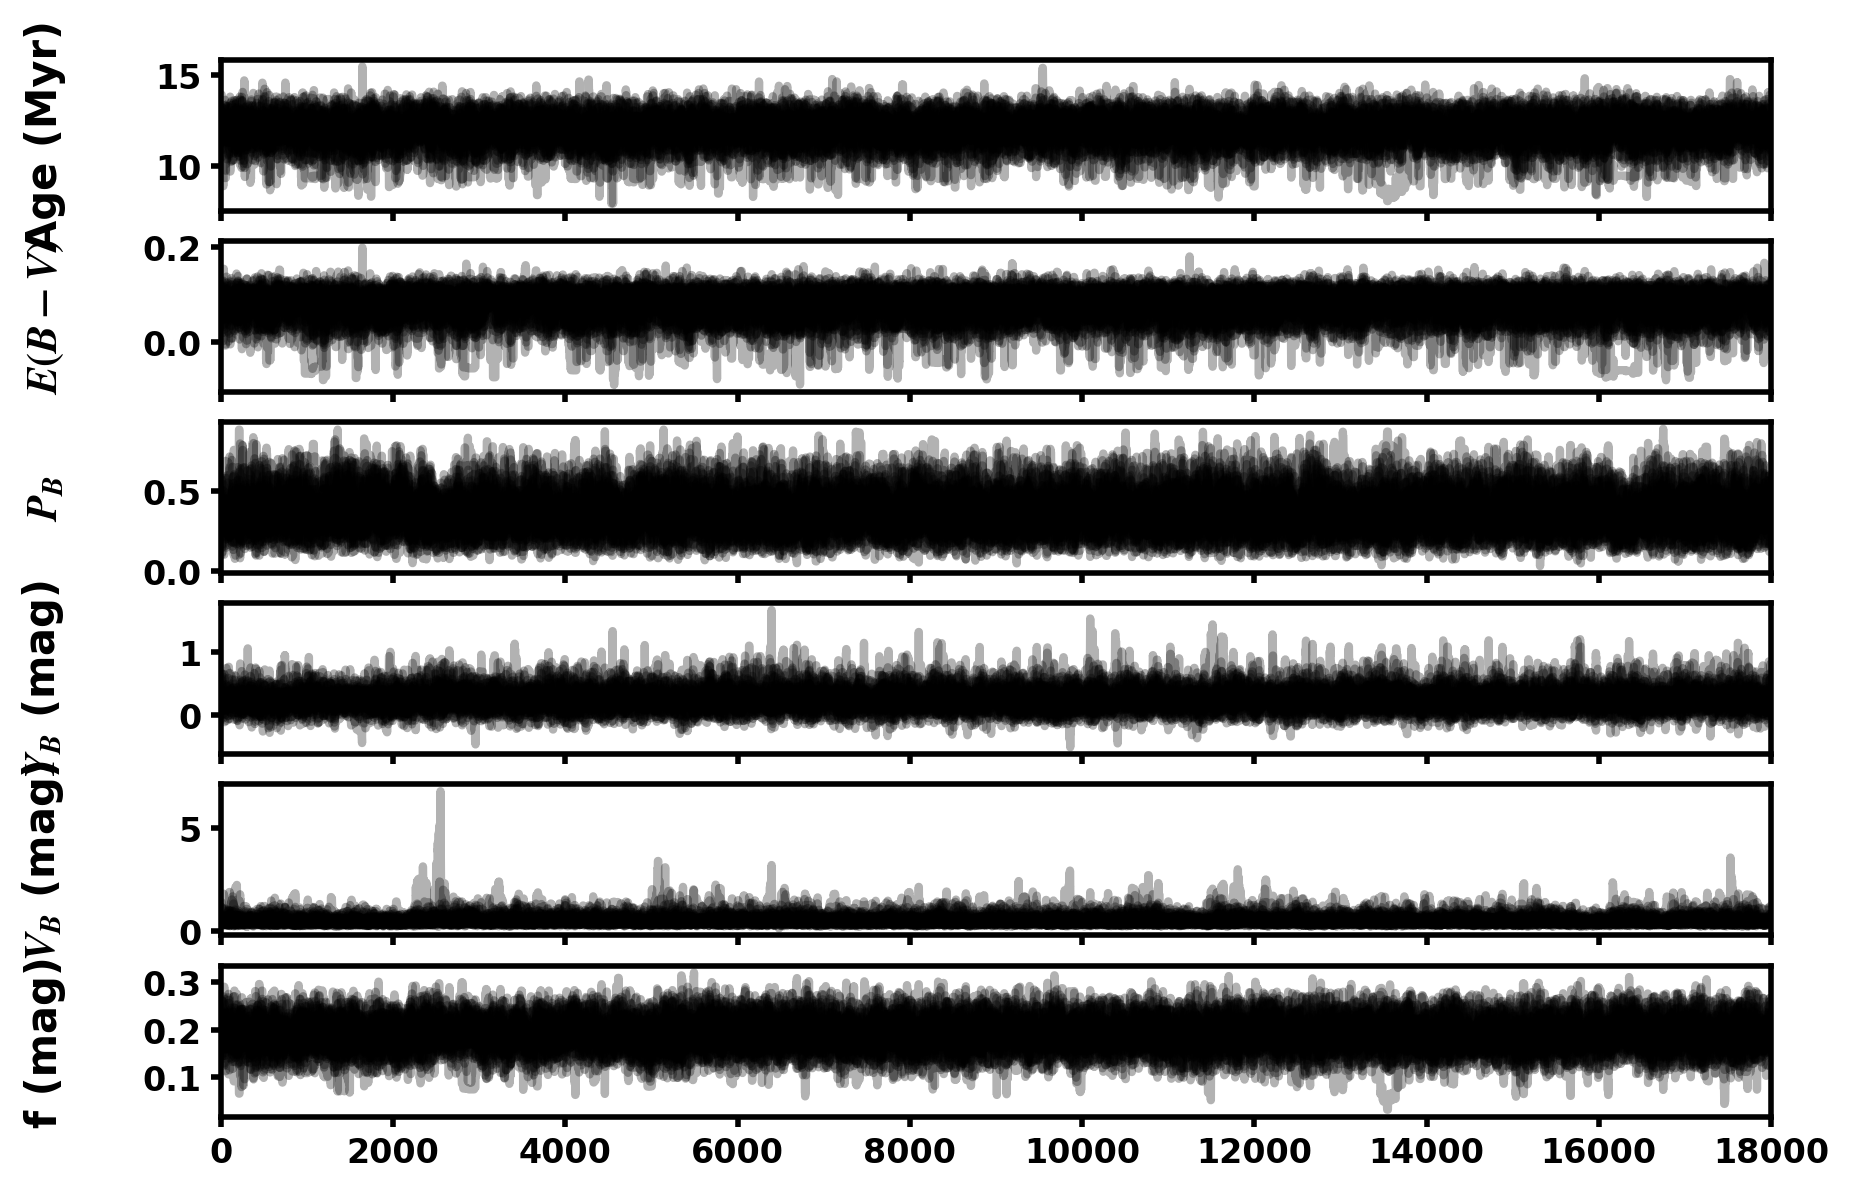

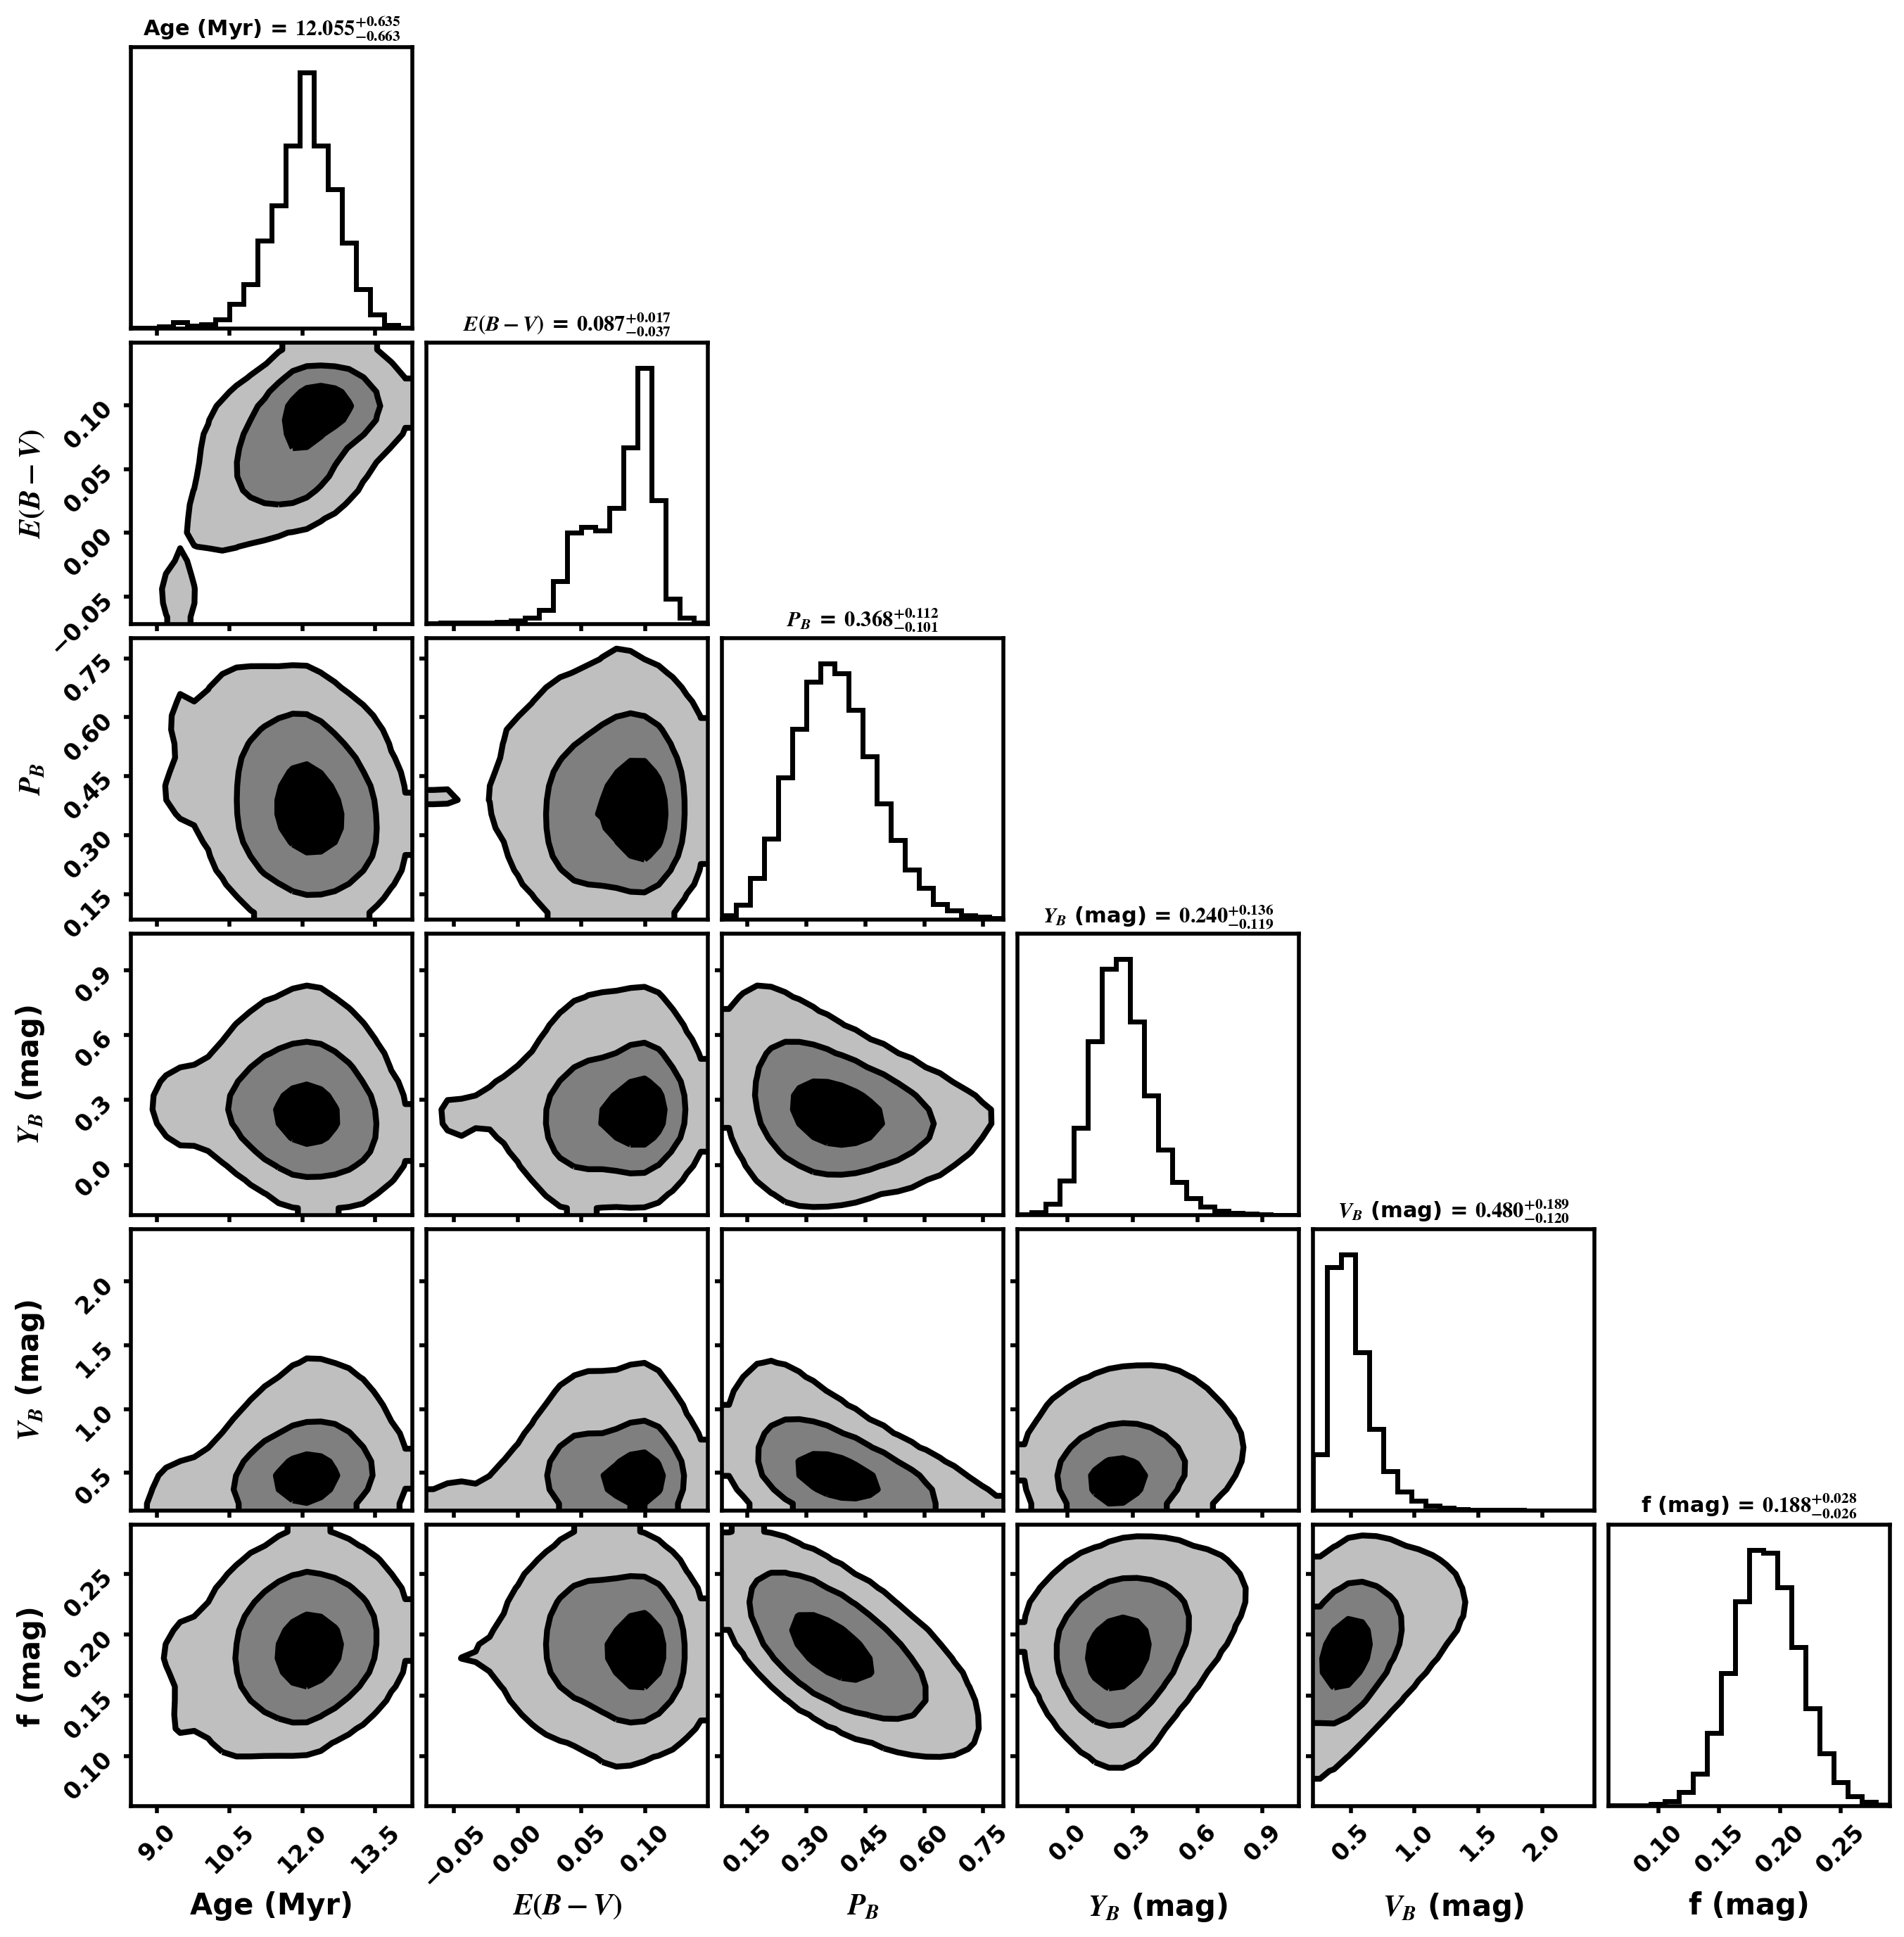

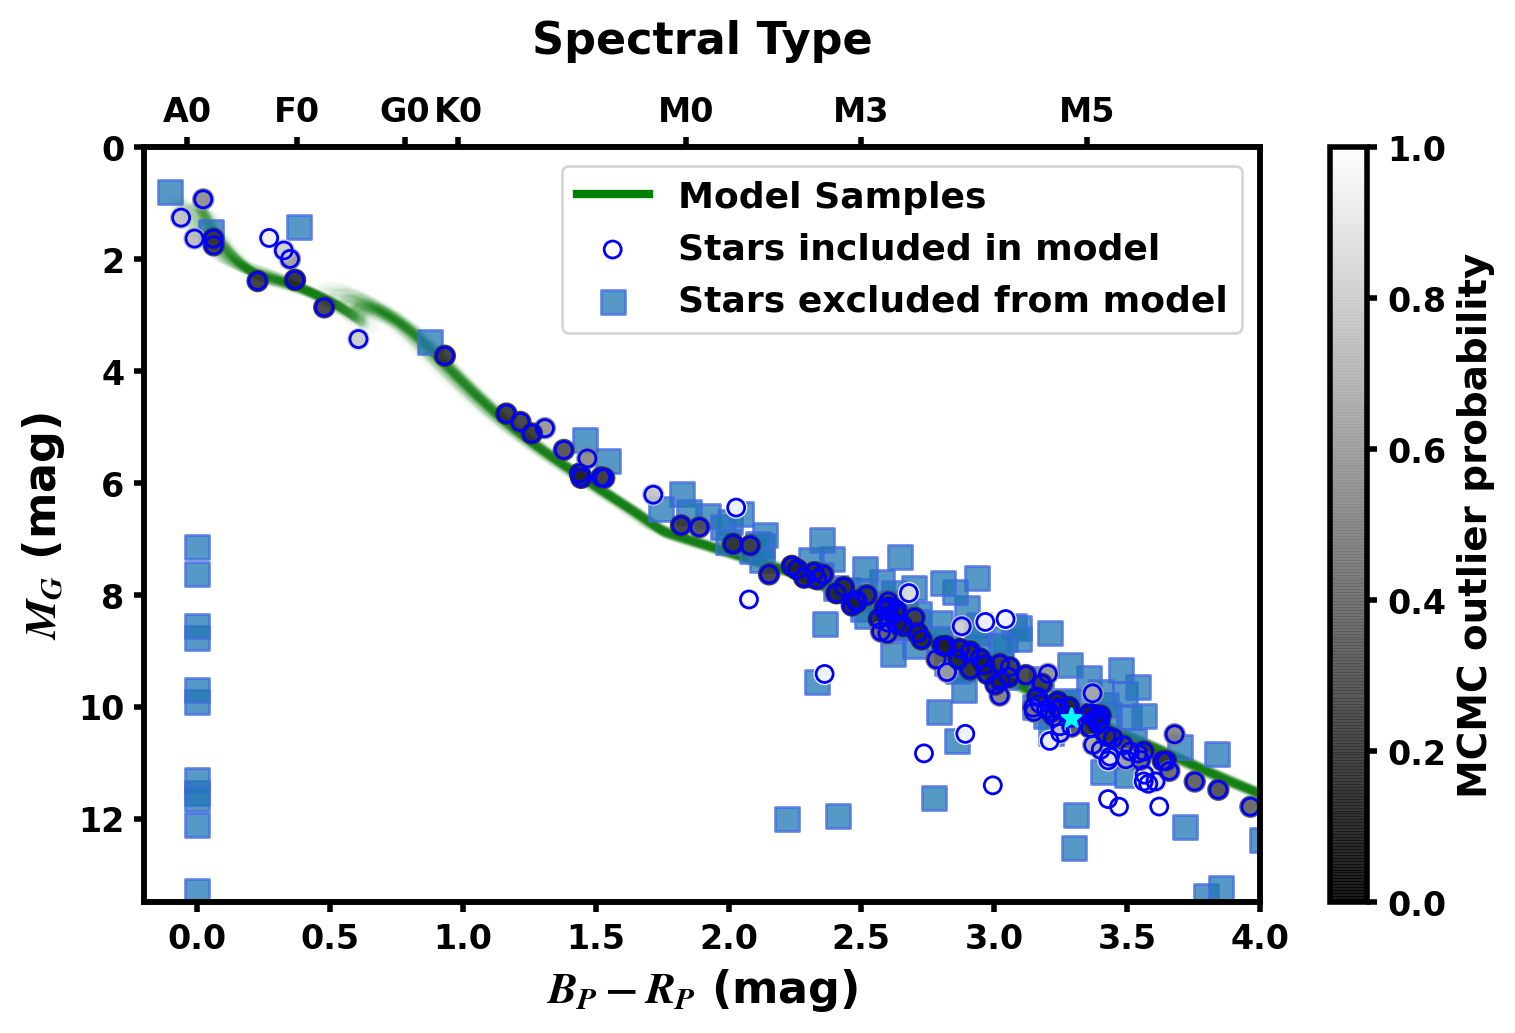

In [13]:
## plotting!!!

samples = sampler.get_chain(discard=burn)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = [r'Age (Myr)',r'$E(B-V)$', r'$P_B$',r'$Y_B$ (mag)',r'$V_B$ (mag)','f (mag)']
for i in range(ndim):
     ax = axes[i]
     ax.plot(samples[:, :, i], "k", alpha=0.3)
     ax.set_xlim(0, len(samples))
     ax.set_ylabel(labels[i])
     ax.yaxis.set_label_coords(-0.1, 0.5)
        
fig.set_rasterized(True)
fig.savefig(foldername+'/walker'+file_endian+'.pdf',dpi=400)
          
## check the autocorrelation time (this is to check for convergence)
tau = sampler.get_autocorr_time(tol=0)
#print('Tau for each parameter. If any are >', nsteps//50,' then run a longer chain.')
if np.any(tau > nsteps//50):
    print('You need to run a longer chain')
    print(np.max(tau),nsteps//50)
    log.write('You need to run a longer chain:\n')
    log.write(str(np.max(tau))+','+str(nsteps//50))
else:
    print('Chain at least 50x the autocorrelation time.',int((np.max(tau)*50)//1),nsteps)
    log.write('Chain at least 50x the autocorrelation time. '+str(int((np.max(tau)*50)//1))+' '+str(nsteps)+'\n')
    
## flatten (i.e., dump the separate walkers)
flat_samples = sampler.get_chain(discard=burn, thin=5, flat=True)

fig = corner.corner( 
    flat_samples,show_titles=True, labels=labels,range=[0.9995,0.9995,0.9995,0.9995,0.9995,0.9995],
    smooth=1,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.3f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);
plt.savefig(foldername+'/corner'+file_endian+'.pdf',dpi=400)

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    log.write(txt + '\n')
    display(Math(txt))

## identify the FPs

## this is detailed in DFM's guide, he uses "blob" which I could not get to work
## the basic idea is that we pull out a random set of fit parameters from the mcmc, assign the 
## resulting outlier probs to each point, and save those to post_prob (cumulative). Then divide by the
## total number of random samples we pulled. This gives us the "average" probability that a star is a
## member. 

    
##Note that "outliers" are mostly non-members, but because the models are not perfect, could easily
## just be stars where the models failed
## I had initially hoped this would also catch the binaries, but that does not appear to be happening.
## Instead, the code is handling the binaries by increasing "f" to include most of the binary population.
## this means that the age is probably underestimated. I don't have a simple solution for this right now. 
## we might have to explicitly model the binaries or force f to be smaller. 
norm = 0.0
post_prob = np.zeros(len(col1))
elements = 2000
for i in range(elements):
    index = random.randrange(0, np.size(flat_samples[:,0])-1)
    age,EBV, Pb,Yb,Vb,sys = flat_samples[index,:]
    l = np.squeeze(np.where(np.abs(modelage-age) == np.min(np.abs(modelage-age))))
    redcol = modelcol[l]+EBV*(mag1corr(modelgrp[l])-mag2corr(modelgrp[l]))
    redmag = modelmag[l]+EBV*magcorr(modelgrp[l])
    f = interpolate.interp1d(redcol,redmag,fill_value='extrapolate')
    mag_predict = f(col1)
    mag_predict2 = f(col1+colerr1)
    err2 = np.abs(mag_predict2-mag_predict)
    sigma2 = magerr1**2+err2**2+sys**2
    p_fg = ((1-Pb) / np.sqrt(2 * np.pi * sigma2)) * np.exp(-(mag1-mag_predict)**2/(2 * sigma2))
    ll_fg = np.log(p_fg)
    p_bg = (Pb / np.sqrt(2 * np.pi * (Vb + sigma2))) * np.exp(-((mag1-mag_predict)-Yb)**2/(2 * (Vb + sigma2)))
    
    ll_bg = np.log(p_bg)
    post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
post_prob/=elements
outliers = np.where(post_prob < 0.5)##50% chance of being outliers

 
targsize = 200
## Take out the fit parameters. Note I'm lazily using median=best-fit, which is fine for 
## such a simple relation, but not necessarily OK generally. To get the best fit, use the likelihood
## values from the MCMC chain (check emcee docs).
params = np.array([0.,0.,0.,0.,0.,0.])
for i in range(ndim):
    params[i] = np.percentile(flat_samples[:, i],[50])
    age, EBV, Pb, Yb, Vb, sys = params


fig,ax1 = plt.subplots(figsize=(9,5))
## another way to do this is to color the points by outlier prob to see how the weighting works out
ec = ax1.scatter(col1,mag1,c=1.-post_prob,vmin=0.0 , vmax=1 , cmap='gray',s=50,zorder=3,alpha=0.9)
cb = plt.colorbar(ec , ax=ax1)
ax1.scatter(col1,mag1,marker='.',edgecolors='blue',facecolors='none',s=150,label='Stars included in model',zorder=3)
if np.size(col2) > 1:
    ax1.scatter(col2,mag2,marker='s',edgecolors='royalblue',alpha=0.75,s=50,label='Stars excluded from model',zorder=0)
cb.set_label(label='MCMC outlier probability',fontsize=14)
    
elements2 = 100
for i in range(elements2):
    index = random.randrange(0, np.size(flat_samples[:,0])-1)
    age,EBV, Pb,Yb,Vb,sys = flat_samples[index,:]
    l = np.squeeze(np.where(np.abs(modelage-age) == np.min(np.abs(modelage-age))))
    redcol = modelcol[l]+EBV*(mag1corr(modelgrp[l])-mag2corr(modelgrp[l]))
    redmag = modelmag[l]+EBV*magcorr(modelgrp[l])
    ax1.plot(redcol,redmag,label='_Model',color='green',alpha=2./elements2,zorder=1)
ax1.plot([0],[0],label='Model Samples',color='green',alpha=1)
ax2.scatter(targcol,targmag,marker='*',s=50,label=targname,color='cyan',zorder=5)
ax1.legend(fontsize=13)
ax1.set_xlabel(xlabel , fontsize=16)
ax1.set_ylabel(ylabel, fontsize=16)
ax1.set_xlim(colrange[0],colrange[1])
ax1.set_ylim(magrange[0],magrange[1])

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
if usecol == 'bprp':
    spttickvals = np.array([ -0.037 , 0.377 , 0.782 , 0.983 , 1.84 , 2.50 , 3.35 , 4.65 ])
if usecol == 'grp':
    spttickvals = np.array([ -0.020 , 0.230 , 0.439 , 0.56 , 0.92 , 1.13 , 1.33 , 1.52 ])  
sptticklabs = np.array([ 'A0' , 'F0' , 'G0' , 'K0' , 'M0' , 'M3' , 'M5' , 'M7' ])
xx = np.where( (spttickvals >= colrange[0]) & (spttickvals <= colrange[1]))
ax2.set_xticks(spttickvals[xx])
ax2.set_xticklabels( sptticklabs[xx] )
ax2.set_xlabel('Spectral Type' , fontsize=16, labelpad=15)
ax2.tick_params(axis='both',which='major',labelsize=12)
fig.savefig(foldername+'/CMDcoloroutlier'+file_endian+'.pdf',dpi=400, bbox_inches='tight')

##write the results to a file

## write to a file the rejected sources for manual inspection:
prob_out = foldername+'/Probs_'+file_endian+'.txt'
##   RA, Dec, g, Bp, Rp, Mag, Col, Ruwe
fmt1 = "%11.7f %11.7f %6.3f %6.3f %6.3f"
os.system('rm '+prob_out)
prob = open(prob_out,'x')
prob.write('RA           DEC          color  Mg   Prob  \n')
for i in np.arange(np.size(ra1)):
    j = int(np.squeeze(i))
    prob.write(fmt1 % (ra1[j],dec1[j],col1[j],mag1[j],post_prob[j]))
    prob.write("\n")
    
prob.close()



In [14]:
#ruwe